# 1. Import các package cần thiết

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score

from sklearn.metrics import (
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [102]:
# đặt lại seed để đảm bảo tính tái lập
np.random.seed(42)
tf.random.set_seed(42)

# 2. Đọc & khám phá dữ liệu

In [103]:
df = pd.read_csv('../data/kidney_disease_ckd.csv')
df.head() #hiển thị 5 dòng đầu tiên của dataframe

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,90.0,160.0,1.016956,0.0,3.0,normal,normal,not present,not present,...,49.0,6745.0,3.0,no,no,yes,poor,yes,yes,notckd
1,1,57.0,131.0,1.015917,0.0,5.0,normal,normal,not present,present,...,43.0,7594.0,4.5,no,no,yes,good,no,no,notckd
2,2,34.0,158.0,1.017011,0.0,4.0,abnormal,normal,present,not present,...,37.0,10103.0,5.0,no,no,yes,poor,yes,no,notckd
3,3,35.0,106.0,1.023035,0.0,2.0,normal,abnormal,present,present,...,48.0,4794.0,3.5,yes,yes,no,good,no,yes,notckd
4,4,16.0,155.0,1.024018,0.0,3.0,abnormal,normal,not present,not present,...,28.0,7693.0,3.2,yes,no,no,poor,yes,yes,notckd


In [104]:
#kiểm tra phân bố lớp mục tiêu
df['classification'].value_counts()
df['classification'].value_counts(normalize=True)

classification
ckd       0.570191
notckd    0.429809
Name: proportion, dtype: float64

# 3. Tiền xử lý dữ liệu

In [105]:
#xoá cột 'id' không cần thiết
df = df.drop('id', axis=1)

In [106]:
# danh sách các cột phân loại
categorical_cols = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']

In [107]:
# làm sạch dữ liệu trong các cột phân loại
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.replace('\t', '')
        
df = df.replace(['?', '\t?', ' ?'], np.nan)

In [108]:
# xử lý cột 'classification'
df['classification'] = df['classification'].str.strip()
df['classification'] = df['classification'].astype(str).str.lower()
df['classification'] = df['classification'].str.replace('\t', '', regex=False)

print(df['classification'].unique())

valid_classes = ['ckd', 'notckd']
df = df[df['classification'].isin(valid_classes)].copy()

label_map = {'notckd': 0, 'ckd': 1}
df['classification'] = df['classification'].map(label_map).astype(int)

print("Giá trị nhãn sau khi mã hóa:", df['classification'].unique())


['notckd' 'ckd']
Giá trị nhãn sau khi mã hóa: [0 1]


In [109]:
# lấy danh sách các cột số
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols = [col for col in df.select_dtypes(include=[np.number]).columns
                  if col != 'classification']

In [110]:
# điền giá trị thiếu trong các cột số bằng trung vị
for col in numerical_cols:
    if df[col].isnull().sum() > 0:
         df[col].fillna(df[col].median(), inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_2860\1186552810.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_2860\1186552810.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, 

In [111]:
# mã hóa nhãn cho các cột phân loại
for col in categorical_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        

# 4. Tách nhãn và chia tập dữ liệu

In [112]:
# tách đặc trưng và nhãn mục tiêu
X = df.drop('classification', axis=1)
y = df['classification']

In [113]:
# chia tập dữ liệu thành tập huấn luyện, tập xác thực và tập kiểm tra
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=42,
    stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.1765,       
    random_state=42,
    stratify=y_temp
)

In [114]:
# chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# 6. Xây dựng kiến trúc ANN

In [115]:
# Đinh nghĩa mô hình ANN
def create_ann_model(input_dim):#tang them 1 hiden layer, chuyen ham kich hoat ở các hidden layer tu relu sang LeakyReaLU, them BatchNormalization
    model = Sequential([
        Dense(128, kernel_initializer='he_normal', input_shape=(input_dim,)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),

        Dense(64, kernel_initializer='he_normal'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),

        Dense(32, kernel_initializer='he_normal'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),

        Dense(1, activation='sigmoid')
    ])
    return model

# Tạo mô hình
model = create_ann_model(X_train_scaled.shape[1])

# Xem kiến trúc model
model.summary()


c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 128)            │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,465 (56.50 KB)

 Trainable params: 14,017 (54.75 KB)

 Non-trainable params: 448 (1.75 KB)

# 7. Biên dịch mô hình

In [116]:
# Biên dịch mô hình
model.compile(
    optimizer=Adam(learning_rate=0.0005), #0.001->0.0005
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

# 8. Thiết lập callback

In [117]:
# dừng sớm
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
# lưu mô hình tốt nhất dựa trên độ chính xác xác thực
model_checkpoint = ModelCheckpoint(
    '../model/best_kidney_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)
callbacks = [early_stopping, model_checkpoint]

# 9. Huẩn luyện mô hình

In [118]:
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,# 50->100
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5151 - loss: 0.8168 - precision: 0.6292 - recall: 0.3461

64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5854 - loss: 0.7183 - precision: 0.7187 - recall: 0.4483 - val_accuracy: 0.7783 - val_loss: 0.5137 - val_precision: 0.7631 - val_recall: 0.8866
Epoch 2/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7090 - loss: 0.5623 - precision: 0.8007 - recall: 0.6501

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7286 - loss: 0.5436 - precision: 0.8092 - recall: 0.6855 - val_accuracy: 0.8129 - val_loss: 0.4519 - val_precision: 0.8458 - val_recall: 0.8219
Epoch 3/100
54/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7614 - loss: 0.5065 - precision: 0.8069 - recall: 0.7648

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7870 - loss: 0.4816 - precision: 0.8292 - recall: 0.7889 - val_accuracy: 0.8268 - val_loss: 0.4217 - val_precision: 0.8675 - val_recall: 0.8219
Epoch 4/100
58/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8064 - loss: 0.4395 - precision: 0.8434 - recall: 0.8103

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8068 - loss: 0.4392 - precision: 0.8370 - recall: 0.8210 - val_accuracy: 0.8291 - val_loss: 0.3977 - val_precision: 0.8712 - val_recall: 0.8219
Epoch 5/100
55/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8194 - loss: 0.4205 - precision: 0.8313 - recall: 0.8567

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8252 - loss: 0.4151 - precision: 0.8359 - recall: 0.8627 - val_accuracy: 0.8430 - val_loss: 0.3821 - val_precision: 0.8714 - val_recall: 0.8502
Epoch 6/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8414 - loss: 0.4084 - precision: 0.8440 - recall: 0.8845

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8435 - loss: 0.3992 - precision: 0.8465 - recall: 0.8862 - val_accuracy: 0.8522 - val_loss: 0.3674 - val_precision: 0.8765 - val_recall: 0.8623
Epoch 7/100
62/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8525 - loss: 0.3825 - precision: 0.8498 - recall: 0.8999

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8514 - loss: 0.3756 - precision: 0.8496 - recall: 0.8983 - val_accuracy: 0.8614 - val_loss: 0.3582 - val_precision: 0.8755 - val_recall: 0.8826
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8445 - loss: 0.3799 - precision: 0.8439 - recall: 0.8923 - val_accuracy: 0.8614 - val_loss: 0.3441 - val_precision: 0.8725 - val_recall: 0.8866
Epoch 9/100
61/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8584 - loss: 0.3737 - precision: 0.8524 - recall: 0.9082

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8623 - loss: 0.3607 - precision: 0.8546 - recall: 0.9140 - val_accuracy: 0.8707 - val_loss: 0.3309 - val_precision: 0.8745 - val_recall: 0.9028
Epoch 10/100
55/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8525 - loss: 0.3525 - precision: 0.8349 - recall: 0.9238

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8628 - loss: 0.3378 - precision: 0.8496 - recall: 0.9227 - val_accuracy: 0.8868 - val_loss: 0.3193 - val_precision: 0.8779 - val_recall: 0.9312
Epoch 11/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8668 - loss: 0.3298 - precision: 0.8528 - recall: 0.9262 - val_accuracy: 0.8868 - val_loss: 0.3122 - val_precision: 0.8750 - val_recall: 0.9352
Epoch 12/100
48/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8594 - loss: 0.3297 - precision: 0.8442 - recall: 0.9236

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8757 - loss: 0.3159 - precision: 0.8577 - recall: 0.9374 - val_accuracy: 0.8915 - val_loss: 0.3059 - val_precision: 0.8759 - val_recall: 0.9433
Epoch 13/100
58/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8646 - loss: 0.3226 - precision: 0.8448 - recall: 0.9335

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8732 - loss: 0.3113 - precision: 0.8521 - recall: 0.9409 - val_accuracy: 0.8938 - val_loss: 0.3027 - val_precision: 0.8792 - val_recall: 0.9433
Epoch 14/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8787 - loss: 0.3119 - precision: 0.8641 - recall: 0.9340 - val_accuracy: 0.8938 - val_loss: 0.2999 - val_precision: 0.8764 - val_recall: 0.9474
Epoch 15/100
59/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8601 - loss: 0.3193 - precision: 0.8451 - recall: 0.9233

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8727 - loss: 0.3116 - precision: 0.8531 - recall: 0.9383 - val_accuracy: 0.8961 - val_loss: 0.2943 - val_precision: 0.8769 - val_recall: 0.9514
Epoch 16/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8782 - loss: 0.2955 - precision: 0.8549 - recall: 0.9470 - val_accuracy: 0.8938 - val_loss: 0.2948 - val_precision: 0.8764 - val_recall: 0.9474
Epoch 17/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8841 - loss: 0.2960 - precision: 0.8607 - recall: 0.9505 - val_accuracy: 0.8961 - val_loss: 0.2902 - val_precision: 0.8769 - val_recall: 0.9514
Epoch 18/100
53/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8807 - loss: 0.2864 - precision: 0.8559 - recall: 0.9504

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8767 - loss: 0.2952 - precision: 0.8551 - recall: 0.9435 - val_accuracy: 0.8984 - val_loss: 0.2911 - val_precision: 0.8801 - val_recall: 0.9514
Epoch 19/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8905 - loss: 0.2893 - precision: 0.8656 - recall: 0.9566 - val_accuracy: 0.8984 - val_loss: 0.2964 - val_precision: 0.8801 - val_recall: 0.9514
Epoch 20/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8910 - loss: 0.2675 - precision: 0.8692 - recall: 0.9522 - val_accuracy: 0.8938 - val_loss: 0.2947 - val_precision: 0.8708 - val_recall: 0.9555
Epoch 21/100
54/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8868 - loss: 0.2801 - precision: 0.8603 - recall: 0.9566

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8841 - loss: 0.2841 - precision: 0.8642 - recall: 0.9453 - val_accuracy: 0.9030 - val_loss: 0.2950 - val_precision: 0.8782 - val_recall: 0.9636
Epoch 22/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8925 - loss: 0.2717 - precision: 0.8748 - recall: 0.9470 - val_accuracy: 0.8984 - val_loss: 0.2958 - val_precision: 0.8745 - val_recall: 0.9595
Epoch 23/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8881 - loss: 0.2731 - precision: 0.8674 - recall: 0.9487 - val_accuracy: 0.9007 - val_loss: 0.2970 - val_precision: 0.8778 - val_recall: 0.9595
Epoch 24/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8940 - loss: 0.2579 - precision: 0.8698 - recall: 0.9574 - val_accuracy: 0.9007 - val_loss: 0.2957 - val_precision: 0.8750 - val_recall: 0.9636
Epoch 25/100
52/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8813 - loss: 0.2715 - precision: 0.8606 - recall: 0.9449

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8940 - loss: 0.2617 - precision: 0.8757 - recall: 0.9487 - val_accuracy: 0.9076 - val_loss: 0.2972 - val_precision: 0.8819 - val_recall: 0.9676
Epoch 26/100
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8855 - loss: 0.2690 - precision: 0.8620 - recall: 0.9507

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8905 - loss: 0.2624 - precision: 0.8708 - recall: 0.9487 - val_accuracy: 0.9099 - val_loss: 0.2953 - val_precision: 0.8852 - val_recall: 0.9676
Epoch 27/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8876 - loss: 0.2706 - precision: 0.8696 - recall: 0.9444 - val_accuracy: 0.9099 - val_loss: 0.2921 - val_precision: 0.8852 - val_recall: 0.9676


# 10. Đánh giá và lưu mô hình

In [119]:
# đánh giá mô hình trên tập test
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [120]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(
    X_test_scaled,
    y_test,
    verbose=0
)
test_f1 = f1_score(y_test, y_pred)
print("Unique labels in y:", sorted(y.unique()))
print("Unique labels in y_test:", sorted(y_test.unique()))

Unique labels in y: [np.int64(0), np.int64(1)]
Unique labels in y_test: [np.int64(0), np.int64(1)]


In [121]:
# in ra các chỉ số đánh giá
classification_report(y_test, y_pred, target_names=['Not CKD', 'CKD'])

'              precision    recall  f1-score   support\n\n     Not CKD       0.85      0.80      0.82       186\n         CKD       0.85      0.89      0.87       247\n\n    accuracy                           0.85       433\n   macro avg       0.85      0.84      0.85       433\nweighted avg       0.85      0.85      0.85       433\n'

<Axes: >

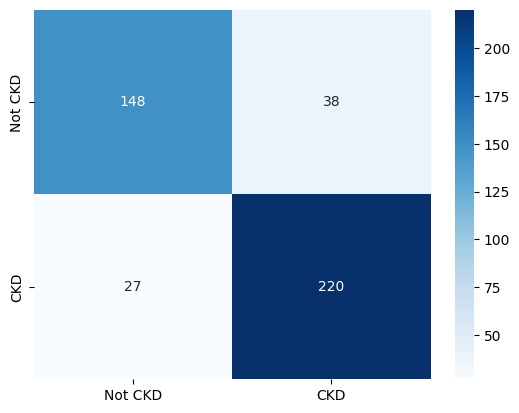

In [122]:
#  vẽ ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not CKD', 'CKD'], yticklabels=['Not CKD', 'CKD'])

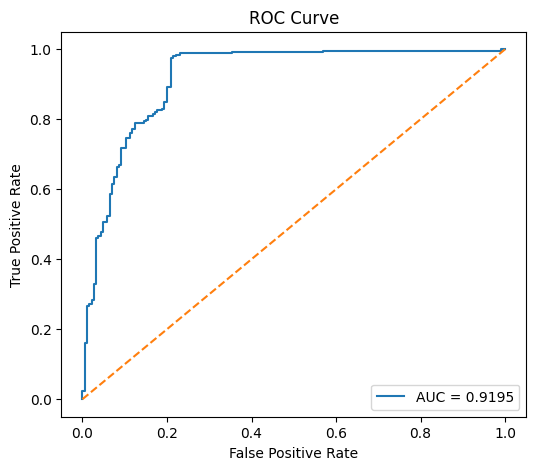

In [123]:
# Tính FPR, TPR và AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Vẽ biểu đồ
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")  # đường random
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [124]:
#  hàm dự đoán bệnh
def predict_kidney_disease(model, scaler, features):
    features_scaled = scaler.transform([features])
    probability = model.predict(features_scaled)[0][0]
    prediction = 1 if probability > 0.5 else 0
    return prediction, probability

In [125]:
# lưu mô hình và bộ scaler
model.save('../model/kidney_disease_model.h5')
joblib.dump(scaler, '../model/scaler.pkl')

['../model/scaler.pkl']